# Tutorial II: Optimization in TensorFlow & NN introduction

<p>
Bern Winter School on Machine Learning, 2022<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

## 1. Load necessary libraries

In [1]:
colab = True # set to True is using google colab

In [2]:
if colab:
    %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import os
import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext tensorboard

## 2. Linear fit

Here we will solve optimization problem to perform linear regression. First we will generate training set of 80 data points and test set of 20, laying on a line with a random offset $$y = a_0 x + b_0 + \delta,$$ where $\delta$ is a random variable sampled from a uniform distribution with standard deviation equal to $s_0$

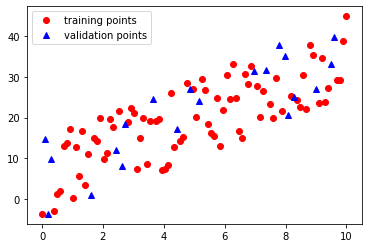

In [41]:
a0 = 3  # 3
b0 = 5  # 5
s0 = 10  # 1

# all samples
x_all = np.linspace(0, 10, 100)  # 100 points
n_all = x_all.shape[0]
d_all = np.random.uniform(-s0, s0, size=n_all)
y_all = np.asarray([a0*x + b0 + d for x, d in zip(x_all, d_all)])
    
# randomize order and get 80% for training
idx = np.random.permutation(n_all)
n_train = n_all * 80 // 100

idx_train = idx[0:n_train]
idx_val = idx[n_train:]

x_train = x_all[idx_train]
y_train = y_all[idx_train]

x_val = x_all[idx_val]
y_val = y_all[idx_val]

plt.plot(x_train, y_train, "or", x_val, y_val, "b^")
plt.legend(('training points', 'validation points'),  loc='upper left')

We will then define loss function as the mean of squared residuals (distance from line along $y$) for the points.

We will use [stochactic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent): on each iteration use only a fraction (`batch_size`) of all training set. In many cases training set is huge and cannot be fed on each iteration in principle. Also it can sometimes help the optimizer to properly explore the manifold.

In [42]:
class Linear(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def build(self, input_shape):
    self.a = self.add_weight(initializer=tf.keras.initializers.random_normal(), # two variables to minimize (intercept and regression weight)
                             name='a', dtype=tf.float32)
    self.b = self.add_weight(initializer=tf.keras.initializers.random_normal(),
                             name='a', dtype=tf.float32)
    super().build(input_shape)

  def call(self, x):
    f = self.a * x + self.b
    return f

def loss_f(true_y, y_predicted):
  residual = true_y - y_predicted
  squared_residual = residual ** 2
  mean_squared_residual = tf.reduce_mean(squared_residual)
  return mean_squared_residual
    
x = tf.keras.layers.Input(name='x', dtype=tf.float32, shape=())
y = Linear()(x)

model = tf.keras.Model(inputs=x, outputs=y)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.002)
model.compile(optimizer=optimizer, loss=loss_f)  # we could just use `loss='mse'` - it does the very same thing
model.summary()


batch_size = 10 # 10 --> 8 batches in the training set

hist = model.fit(x=x_train, y=y_train, 
                 batch_size=batch_size,
                 epochs=300, shuffle=True,
                 validation_data=(x_val, y_val), 
                 )

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None,)]                 0         
                                                                 
 linear_14 (Linear)          (None,)                   2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 [==============================] - 0s 18ms/step - loss: 252.4699 - val_loss: 125.5043
Epoch 2/300
8/8 [==============================] - 0s 4ms/step - loss: 69.1494 - val_loss: 62.1374
Epoch 3/300
8/8 [==============================] - 0s 4ms/step - loss: 50.3963 - val_loss: 51.7189
Epoch 4/300
8/8 [==============================] - 0s 5ms/step - loss: 48.3016 - val_loss: 50.1586
Epoch 5/300
8/8 [==============================] - 0s 5ms/ste

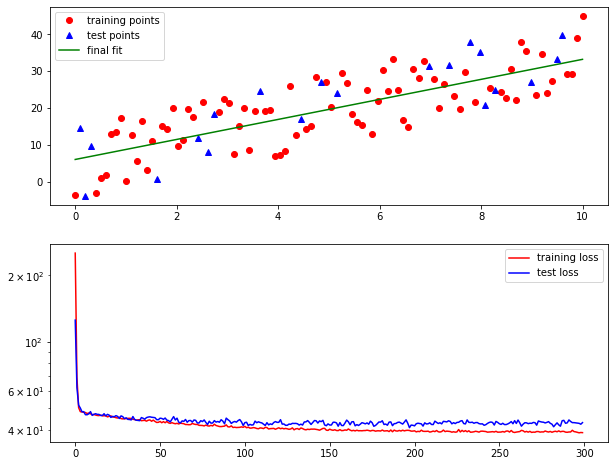

In [43]:
a_val, b_val = model.get_weights()
        
end_fit_x = [x_all[0], x_all[-1]]
end_fit_y = [a_val*x+b_val for x in end_fit_x]
true_fn_y = [a0*x+b0 for x in end_fit_x]

fig, axs = plt.subplots(2, 1, figsize=(10,8))
axs[0].plot(x_train, y_train, 'ro', x_val, y_val, 'b^', end_fit_x, end_fit_y, 'g')
axs[0].legend(('training points', 'test points', 'final fit'),  loc='upper left')

ep_arr = hist.epoch
axs[1].semilogy(ep_arr, hist.history['loss'], 'r')
axs[1].semilogy(ep_arr, hist.history['val_loss'], 'b')
axs[1].legend(('training loss', 'test loss'),  loc='upper right');

if test goes up again --> sign for overfitting



## 3. Exercise 1

Play with the true function parameters ```a0, b0, s0``` and the ``batch_size`` value, check how it affects the convergence.

1. How change of `s0` affects convergance?
2. When one should stop training to prevent overfitting?


if batch size is higher --> curve will be stretched
if batch size is lower --> curve will be noisy, and more to the left
smaller batch sizes --> it takes longer, inefficient

strategy in practice:
* batch size as high as possible (might not work if its too high)
* bigger learning rate, as long as it doesnt make weird stuff
* 


## 4. Training loop

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, batches, and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

## 5. Bulding blocks of a neural network

Neural network consists of layers of neurons. Each neuron perfroms 2 operations.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/Perceptron.png" alt="drawing" width="30%"/>

1. Calculate the linear transformation of the input vector $\bar x$: 
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.
2. Perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$ Here we will use rectified linear unit activation.

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$: $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vactor.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/>

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [ ]:
#tf.keras.layers.Dense??

In [ ]:
class Dense(tf.keras.layers.Layer):
  def __init__(self,
               units,
               activation=None,
               ):
    """Fully connected layer.

    Parameters
    ----------
    units : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    super(self).__init__(**kwargs)
    self.units = int(units)
    self.activation = activations.get(activation)

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    last_dim = tf.compat.dimension_value(input_shape[-1])

    self.kernel = self.add_weight(
        'kernel',
        shape=[last_dim, self.units],
        initializer=self.kernel_initializer,
        dtype=self.dtype,
        trainable=True)
    

    self.bias = self.add_weight(
          'bias',
          shape=[self.units,],
          initializer=self.bias_initializer,
          dtype=self.dtype,
          trainable=True)

  def call(self, inputs):
    outputs = tf.matmul(a=inputs, b=self.kernel)
    outputs = tf.nn.bias_add(outputs, self.bias)

    if self.activation is not None:
      outputs = self.activation(outputs)


In the case of classification, in the the last layer we use *softmax* transformation as non-linear transformation: $$y_i = \sigma(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

This will correspond to the one-hot labels that we use.
Finally we will use the cross entropy between output $y$ and the ground truth (GT) $y_{GT}$ as the loss function: $$H(y, y_{GT}) = - \sum_i y_{GT, i} \log(y_{i})$$


## 6. Bulding a neural network

In [ ]:
n_input = 10
n_output = 2

In [ ]:
x = tf.keras.layers.Input(name='X', dtype=tf.float32, shape=[n_input])

#layer 1: 10 inputs -> 4, sigmoid activation
l1 = tf.keras.layers.Dense(units=4, name='L1', activation='sigmoid')(x)

#layer 2: 4 inputs -> 2, softmax activation
l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='softmax')(l1)
   
#prediction: onehot->integer
pred = tf.argmax(l2, axis=1, name='pred')

model = tf.keras.Model(inputs=x, outputs=[l2, pred])

In [ ]:
print(x)
print(l1)
print(l2)
print(pred)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

https://medium.com/geekculture/how-visualizations-help-make-sense-of-deep-learning-a408ab00688f